# Converting EtOAc Data

In Yates & McClellane, 1967 there are reported values for rate vs [H2SO4] in extreme acid mixtures for hydrolysis of esters. The author include EtOAc data in their plots but do not repport the values in Table 1 of that paper.

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

We are pointed to work by Bell and also by Jaques

"The Kinetics of Ester Hydrolysis in Concentrated Aqueous Acids." R.P. Bell, A.L. Dowding, J.A. Noble, *J. Chem. Soc.* **1955**, 3106–3110. https://doi.org/10.1039/JR9550003106.

"The Hydrolysis of Ethyl Acetate in Concentrated Aqueous Sulphuric Acid." D. Jaques, *J. Chem. Soc.* **1965**, 3854–3904. https://doi.org/10.1039/JR9650003854.

Both report rates in sulphuric acid solution.  The data from Jaques is %H2SO4 but the data from Bell is in molar. Fortunately the H0 values are reported and we have built interpolator functions that use data sets of H0 vs %H2SO4 that can convert H0 to %H2SO4.

We can also attempt a more cumbersome conversion by converting the molarity to %H2SO4 using molar mass and tables of density vs conc. Will both of these methods agree?



## Setup

the code below will setup libraries and variables

In [2]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2SO4byPercentWtinH0()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


## Comparing Data

Below we will plot the data for %H2SO4 reported by Lane using the values of Bell and my own converion of the molar concentrations reported by Bell to %H2SO4 



In [3]:
###################################################
### Import the data and perform calculations
###################################################

Data_File_Name = "Bell1955.csv"
Filename = github_location + Data_File_Name

df_Bell = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

print("Data from Bell 1955\n")

interpolator_H0 = interpolators.MakeInterpolationFunctionForH2SO4byPercentWtbyMolarConc()
Percent = interpolator_H0(df_Bell["[H2SO4] mole/L"])
df_Bell["%H2SO4"] = Percent

Data_File_Name = "Lane1968.csv"
Filename = github_location + Data_File_Name

df_Lane = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

percents_lane = df_Lane["%[H2SO4]"].to_numpy()
mask = [1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0]
mask = np.array(mask, dtype=bool)
percents_lane = percents_lane[mask]

percents_bell = df_Bell["%H2SO4"].to_numpy()
mask = [1,0,1,1,1,1,1,1,1]
mask = np.array(mask, dtype=bool)
percents_bell = percents_bell[mask]


display(df_Bell)
display(percents_lane)
display(percents_bell)

Data from Bell 1955



,[H2SO4] mole/L,10^5 kobs,H0,%H2SO4
0,1.35,18.8,-0.31,11.992702
1,1.37,19.8,-0.33,12.157030
2,1.87,30.9,-0.62,16.202243
3,2.85,56.1,-1.15,23.714755
4,3.08,65.5,-1.25,25.390681
5,3.63,79.7,-1.50,29.263192
6,4.25,104.0,-1.80,33.408467
7,4.76,128.0,-2.05,36.654794
8,6.75,192.0,-3.03,48.110851


array([12.2 , 16.4 , 23.9 , 25.5 , 29.4 , 33.43, 36.67, 48.  ])

array([11.99270194, 16.20224302, 23.71475515, 25.39068094, 29.26319159,
       33.4084672 , 36.65479429, 48.11085146])

## Check Results

Here are the two sets of data plotted against each other and a plot of the differences. They should be identical and are very very close. the tables for properties of sulphuric acid mixtures have chamnges a little bit between 1968 and 2025.

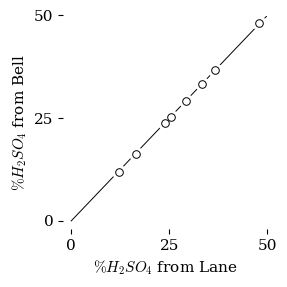

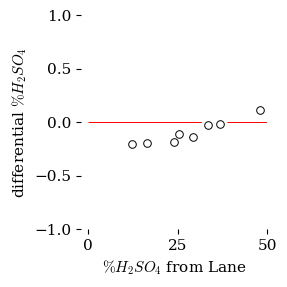

Mean differential is -0.095 +/- 0.105
Standard error of the mean is 0.040
95% confidence interval of the mean is 0.093


In [4]:
x = percents_lane
y = percents_bell
###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from Lane" 
y_label = r"$\%H_2SO_4$ from Bell" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-2,50]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
ax.set(xticks = [0,25,50],
       yticks = [0,25,50]
        )
# 1:1 line
x1 = np.linspace(0, 50, 100)
y1 = x1
ax.plot(x1, y1, 
        color = "black", linewidth=0.7, linestyle="-", 
        zorder = 0)     
plt.savefig("plots/plot3.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################

diff = y - x
#df_Bell["Difference"] = diff
#display(df_Bell)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from Lane" 
y_label = r"differential $\%H_2SO_4$" 


###################################################
### Differential Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-1,1]
        )
# Data points for kobs vs Acidity

ax.scatter(x, diff, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, diff,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
        )
ax.hlines(0, xmin=0, xmax=50, colors="red", linestyles="solid", linewidth=0.7, zorder=0)
plt.savefig("plots/plot4.pdf")
plt.show()

mean = np.mean(diff)
print(f"Mean differential is {mean:0.3f} +/- {np.std(diff):0.3f}")

# stderr from standard deviation of the mean
stdev = stats.sem(diff)
print(f"Standard error of the mean is {stdev:0.3f}")
# 95% confidence interval of the mean
conf95 = stdev * stats.t.ppf((1 + 0.95) / 2., len(diff)-1)
print(f"95% confidence interval of the mean is {conf95:0.3f}")
#conf95range = stats.t.interval(0.95, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))-mean


